<a href="https://colab.research.google.com/github/ErikSeras/usos_r_python/blob/main/analisis_espacial/003_sentinel_5p_tropomi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapa de concentraciones de dióxido de nitrógeno de Sentinel 5P - TROPOMI

Elaborado por: __Erik Seras__

# 1 Instalaciones previas

Archivos que ayudan a procesar data espacial.

In [ ]:
! sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable
! sudo apt-get update
! sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev
! sudo apt-get install libprotobuf-dev protobuf-compiler libv8-dev libjq-dev

https://stackoverflow.com/questions/40374441/python-basemap-module-impossible-to-import

In [ ]:
# Instalar basemap
! sudo apt-get install geos
! sudo pip3 install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
# Necesario para trabajar con archivos netCDF
! pip install netCDF4

# 2 Descarga de los datos

Sitio de datos de la NASA para este ejercicio: [GES DISC](https://disc.gsfc.nasa.gov/)

Pasos para poder descargar datos de GES DISC en Google Colab:
1. Crear tu cuenta de https://earthdata.nasa.gov/
2. Obtener permiso para poder descargar con tu cuenta de GES DISC https://disc.gsfc.nasa.gov/earthdata-login
3. Seguir los pasos indicados dependiendo de su entorno de ejecución https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Download%20Data%20Files%20from%20HTTPS%20Service%20with%20wget. En la sección 2.1 se describirá la forma directa de descargar estos datos en el entorno de Google Colab.

Archivos a descargar (encontrados manualmente en [Earth Data](https://search.earthdata.nasa.gov/search)):

- https://tropomi.gesdisc.eosdis.nasa.gov/data//S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.1/2019/334/S5P_OFFL_L2__NO2____20191130T174805_20191130T192935_11043_01_010302_20191206T203339.nc (30-11-2019)
- https://tropomi.gesdisc.eosdis.nasa.gov/data//S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.1/2020/076/S5P_OFFL_L2__NO2____20200316T174758_20200316T192929_12561_01_010302_20200319T151817.nc (16-03-2020)


Tutoriales que ayudaron al desarrollo del presente ejercicio:
- https://www.youtube.com/watch?v=mqpArrCvw9c (Manejo de archivos netCDF con datos de Sentinel 5P - TROPOMI)

## 2.1 Archivos necesarios para descargar datos de GES DISC

In [27]:
# En Google Colab se requiere crear los archivos .netrc y .urs_cookies en /root/
! touch /root/.netrc
# donde <uid> es su nombre de usuario y <password> es su contraseña de
# inicio de sesión de Earthdata sin corchetes
! echo "machine urs.earthdata.nasa.gov login <uid> password <password>" >> /root/.netrc
! chmod 0600 /root/.netrc
! touch /root/.urs_cookies

## 2.2 Descarga de los archivos a utilizar

In [ ]:
# Descargar en el directorio de trabajo actual

# Data de NO2 del 30-11-2019 (aprox. 434 MB)
! wget --load-cookies /root/.urs_cookies --save-cookies /root/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition https://tropomi.gesdisc.eosdis.nasa.gov/data//S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.1/2019/334/S5P_OFFL_L2__NO2____20191130T174805_20191130T192935_11043_01_010302_20191206T203339.nc

# Data de NO2 del 30-11-2019 (aprox. 433 MB)
! wget --load-cookies /root/.urs_cookies --save-cookies /root/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition https://tropomi.gesdisc.eosdis.nasa.gov/data//S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.1/2020/076/S5P_OFFL_L2__NO2____20200316T174758_20200316T192929_12561_01_010302_20200319T151817.nc

# 3 Graficar los valores de los archivos netCDF

## 3.1 Librerías necesarias

In [1]:
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap 
import matplotlib.pyplot as plt

## 3.2 Elaborar un gráfico de emisiones de $NO_2$ en Estados Unidos durante el 30-11-2019.

In [2]:
# Leer archivo netCDF
ncd_file = Dataset('S5P_OFFL_L2__NO2____20191130T174805_20191130T192935_11043_01_010302_20191206T203339.nc', 'r')

In [3]:
print(ncd_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    institution: KNMI
    source: Sentinel 5 precursor, TROPOMI, space-borne remote sensing, L2
    summary: TROPOMI/S5P NO2 1-Orbit L2 Swath 7x3.5km
    tracking_id: 8671bc2b-714b-4af2-b18b-5d817a8d7561
    id: S5P_OFFL_L2__NO2____20191130T174805_20191130T192935_11043_01_010302_20191206T203339
    time_reference: 2019-11-30T00:00:00Z
    time_reference_days_since_1950: 25535
    time_reference_julian_day: 2458817.5
    time_reference_seconds_since_1970: 1575072000
    time_coverage_start: 2019-11-30T18:09:40Z
    time_coverage_end: 2019-11-30T19:08:03Z
    time_coverage_duration: PT3503.562S
    time_coverage_resolution: PT0.840S
    orbit: 11043
    references: http://www.tropomi.eu/data-products/nitrogen-dioxide
    processor_version: 1.3.2
    keywords_vocabulary: AGU index terms, http://publications.agu.org/author-resource-center/index-terms/
    keywords: 0345 Pollution, 

In [4]:
# Ver las variables disponibles
ncd_file.groups['PRODUCT'].variables.keys()

odict_keys(['scanline', 'ground_pixel', 'time', 'corner', 'polynomial_exponents', 'intensity_offset_polynomial_exponents', 'layer', 'vertices', 'latitude', 'longitude', 'delta_time', 'time_utc', 'qa_value', 'nitrogendioxide_tropospheric_column', 'nitrogendioxide_tropospheric_column_precision', 'nitrogendioxide_tropospheric_column_precision_kernel', 'averaging_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_total', 'tm5_tropopause_layer_index', 'tm5_constant_a', 'tm5_constant_b'])

In [5]:
# Conocer los valores de dióxido de nitrogeno
ncd_file.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column']

<class 'netCDF4._netCDF4.Variable'>
float32 nitrogendioxide_tropospheric_column(time, scanline, ground_pixel)
    units: mol m-2
    standard_name: troposphere_mole_content_of_nitrogen_dioxide
    long_name: Tropospheric vertical column of nitrogen dioxide
    coordinates: longitude latitude
    ancillary_variables: nitrogendioxide_tropospheric_column_precision air_mass_factor_troposphere air_mass_factor_total averaging_kernel
    multiplication_factor_to_convert_to_molecules_percm2: 6.02214e+19
    _FillValue: 9.96921e+36
path = /PRODUCT
unlimited dimensions: 
current shape = (1, 4172, 450)
filling on

In [6]:
# Guardar los datos en variables lat, long y no2_data
lat = ncd_file.groups['PRODUCT'].variables['latitude'][0, :, :]
lon = ncd_file.groups['PRODUCT'].variables['longitude'][0, :, :]
no2_data = ncd_file.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0, :, :]

In [7]:
# Extrayendo el valor de relleno
fill_value = ncd_file.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column']._FillValue
fill_val = fill_value*1000000

In [8]:
# Reemplazo de los valores de relleno/valores perdidos por 'nan'
no2_em = np.array(no2_data)*1000000
no2_em[no2_em == fill_val] = np.nan
no2_data = no2_em

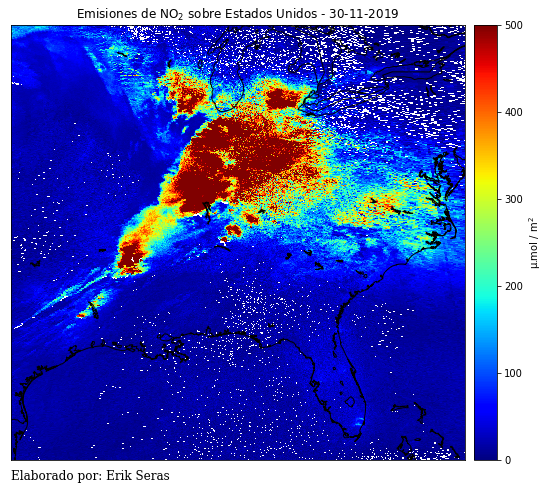

In [9]:
# Modificar el tamaño del gráfico
plt.figure(figsize=(10,8))

# Crear un basemap
m = Basemap(projection = 'cyl', resolution = 'i', 
            llcrnrlat = -90, 
            urcrnrlat = 90,
            llcrnrlon = -180,
            urcrnrlon = 180)  

# Añadir bordes las costas
m.drawcoastlines(linewidth = 1)
# Añadir bordes de los países
m.drawcountries(linewidth = 1)

# Elaborar la barra de colores
cmap = plt.cm.get_cmap('jet')
cmap.set_under('w')
m.pcolormesh(lon, lat, no2_data, latlon = True, vmin =0 , vmax = 500, cmap = cmap)
color_bar = m.colorbar()
color_bar.set_label('μ.mol / m$^{2}$')
plt.autoscale()

# Delimitar la visualización
axes = plt.gca()
axes.set_xlim([-98, -75])
axes.set_ylim([24, 46])

# Añadir texto al gráfico
plt.text(
    x = -98, y = 23, s = 'Elaborado por: Erik Seras',
    fontdict= {
        'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12
})

# Añadir título
plt.title('Emisiones de NO$_{2}$ sobre Estados Unidos - 30-11-2019')

fig = plt.gcf()

# Guardar el gráfico en png
fig.savefig(
    fname = 'NO2_30112019.png', dpi = 300
)

plt.show()

## 3.3 Elaborar un gráfico de emisiones de $NO_2$ en Estados Unidos durante el 16-03-2020.

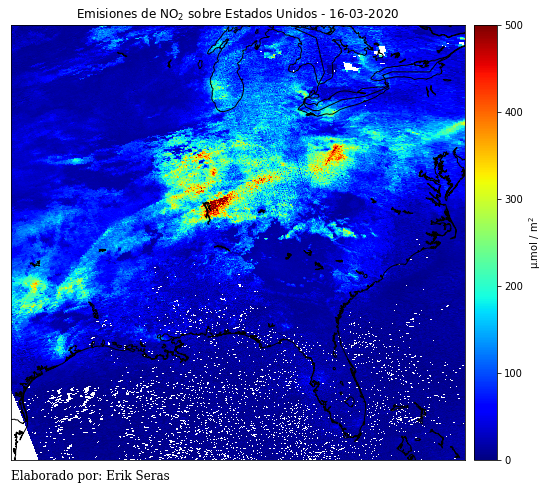

In [10]:
# Leer archivo netCDF
ncd_file = Dataset('S5P_OFFL_L2__NO2____20200316T174758_20200316T192929_12561_01_010302_20200319T151817.nc', 'r')

# Guardar los datos en variables lat, long y no2_data
lat = ncd_file.groups['PRODUCT'].variables['latitude'][0, :, :]
lon = ncd_file.groups['PRODUCT'].variables['longitude'][0, :, :]
no2_data = ncd_file.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0, :, :]

# Extrayendo el valor de relleno
fill_value = ncd_file.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column']._FillValue
fill_val = fill_value*1000000

# Reemplazo de los valores de relleno/valores perdidos por 'nan'
no2_em = np.array(no2_data)*1000000
no2_em[no2_em == fill_val] = np.nan
no2_data = no2_em

# Modificar el tamaño del gráfico
plt.figure(figsize=(10,8))

# Crear un basemap
m = Basemap(projection = 'cyl', resolution = 'i', 
            llcrnrlat = -90, 
            urcrnrlat = 90,
            llcrnrlon = -180,
            urcrnrlon = 180)  

# Añadir bordes las costas
m.drawcoastlines(linewidth = 1)
# Añadir bordes de los países
m.drawcountries(linewidth = 1)

# Elaborar la barra de colores
cmap = plt.cm.get_cmap('jet')
cmap.set_under('w')
m.pcolormesh(lon, lat, no2_data, latlon = True, vmin =0 , vmax = 500, cmap = cmap)
color_bar = m.colorbar()
color_bar.set_label('μ.mol / m$^{2}$')
plt.autoscale()

# Delimitar la visualización
axes = plt.gca()
axes.set_xlim([-98, -75])
axes.set_ylim([24, 46])

# Añadir texto al gráfico
plt.text(
    x = -98, y = 23, s = 'Elaborado por: Erik Seras',
    fontdict= {
        'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12
})

# Añadir título
plt.title('Emisiones de NO$_{2}$ sobre Estados Unidos - 16-03-2020')

fig = plt.gcf()

# Guardar el gráfico en png
fig.savefig(
    fname = 'NO2_16032020.png', dpi = 300
)

plt.show()